**Predicción de si una empresa será zombi 6 años despues**

Cada fila del dataset se corresponde con los **datos de una empresa en un trienio** mas la variable ZombieTarget, que valdrá 1 si esa empresa es zombi trasnscurridos 6 años con respecto a ese trienio. (Será zombi si tienen la tasa de zombificación igual a 1 durante al menos tres años consecutivos)


No se tendrán en cuenta por tanto las variables financieras del peridodo 2017-2022






In [ ]:
import pandas as pd
#from google.colab import drive
import numpy as np
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV,cross_val_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout,Conv1D, GlobalMaxPooling1D
from sklearn.metrics import confusion_matrix,roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier,plot_importance
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE,ADASYN,KMeansSMOTE

from sklearn.decomposition import PCA


from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier

from sklearn.impute import SimpleImputer
from sklearn.svm import SVC

from tensorflow.keras.callbacks import EarlyStopping


from scipy.stats import randint, uniform, loguniform
#import shap


In [ ]:
def balanced_accuracy(y_true, y_pred):





    tp = sum((y_true == 1) & (y_pred == 1))  # True Positives
    tn = sum((y_true == 0) & (y_pred == 0))  # True Negatives
    fp = sum((y_true == 0) & (y_pred == 1))  # False Positives
    fn = sum((y_true == 1) & (y_pred == 0))  # False Negatives

    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    balanced_accuracy = (sensitivity + specificity) / 2

    return balanced_accuracy

In [ ]:

ruta='../../../data/'


df_final = pd.read_csv(ruta+'dfFinal.csv')



In [ ]:
df_final.head(10)


,ID,año,AC,Endeudamiento,FondoManiobra,PT,R,RAGXFI,RAIE,Solvencia,Zombi,SECTOR,RANGO_INGRESOS,EMPLEADOS,EDAD_EMPRESA,TIPOSOC
0,233151.0,0.000000,0.023913,0.453292,0.476216,0.358907,0.476216,0.001411,0.040485,0.080816,0.0,6,5,39.0,51,7
1,233151.0,0.083333,0.026300,0.463274,0.471618,0.355629,0.471618,0.001411,0.043602,0.064498,0.0,6,5,39.0,51,7
2,233151.0,0.166667,0.030259,0.488989,0.473764,0.355992,0.473764,0.001411,0.052536,0.059908,0.0,6,5,39.0,51,7
3,233151.0,0.250000,0.038109,0.507304,0.499606,0.359846,0.499606,0.001411,0.056812,0.059818,0.0,6,5,39.0,51,7
4,233151.0,0.333333,0.022514,0.481316,0.475650,0.360398,0.475650,0.007388,0.046632,0.103046,1.0,6,5,39.0,51,7
5,233151.0,0.416667,0.018757,0.475423,0.471638,0.359969,0.471638,0.003831,0.021428,0.143310,0.0,6,5,39.0,51,7
6,233151.0,0.500000,0.025415,0.478861,0.472171,0.359646,0.472171,0.000274,0.017839,0.082524,0.0,6,5,39.0,51,7
7,233151.0,0.583333,0.025115,0.437031,0.482414,0.344837,0.482414,0.000158,0.020914,0.091303,0.0,6,5,39.0,51,7
8,233151.0,0.666667,0.025089,0.434540,0.478409,0.345915,0.478409,0.000143,0.029336,0.101137,0.0,6,5,39.0,51,7
9,233151.0,0.750000,0.030902,0.445329,0.478157,0.364152,0.478157,0.000264,0.021016,0.077522,0.0,6,5,39.0,51,7


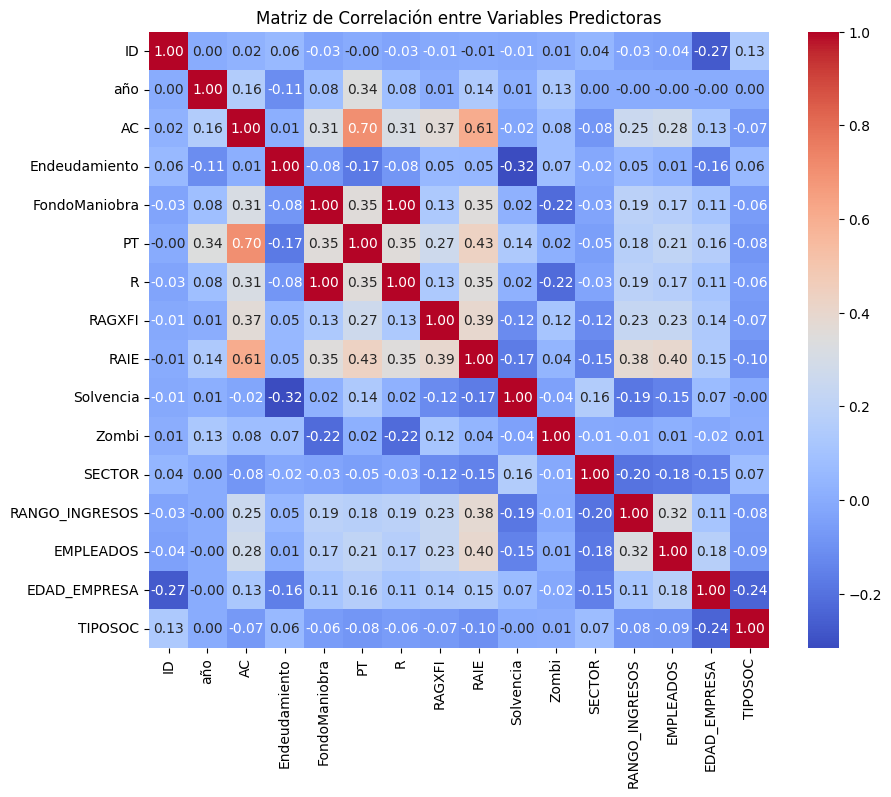

In [ ]:
#Estudio de correlación
correlaciones =df_final.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlaciones, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matriz de Correlación entre Variables Predictoras")
plt.show()

In [ ]:
#Se quitan como variables predictoras los gastos, los resultados y los dfondos maniobra, que  tienen los mismo datoso que los resultados

df_final.drop('FondoManiobra', axis=1, inplace=True)
df_final.drop('RAGXFI', axis=1, inplace=True)
df_final.drop('R', axis=1, inplace=True)


**Preparación del dataset**

Se parte del dataset final, que contiene las variables por empresa y año.

Para cada fila se incluyen las variables de esa empresa de los dos años anteriores para conformar así todos los datos de esa compañía para un trienio dado.

Además para cada fila se genera la variable objetivo ZombiTarget considerando los valores Zombis  del trienio que se quiere predecir

In [ ]:


df_final.sort_values(by=['ID', 'año'], inplace=True)

df_final['ZombiTarget'] = (df_final.groupby('ID')['Zombi'].shift(-4).fillna(0).astype(int) &
                           df_final.groupby('ID')['Zombi'].shift(-5).fillna(0).astype(int) &
                           df_final.groupby('ID')['Zombi'].shift(-6).fillna(0).astype(int))


df_final['Zombi'] = (df_final['Zombi'].astype(int) &
                           df_final.groupby('ID')['Zombi'].shift(-2).fillna(0).astype(int) &
                           df_final.groupby('ID')['Zombi'].shift(-1).fillna(0).astype(int))


df_final['ACPrevio'] = df_final.groupby('ID')['AC'].shift(1)
df_final['ACPrevio'] = df_final['ACPrevio'].fillna(df_final['ACPrevio'].mean())

df_final['ACPrevio2'] = df_final.groupby('ID')['AC'].shift(2)
df_final['ACPrevio2'] = df_final['ACPrevio2'].fillna(df_final['ACPrevio2'].mean())

df_final['EndeudamientoPrevio'] = df_final.groupby('ID')['Endeudamiento'].shift(1)
df_final['EndeudamientoPrevio'] = df_final['EndeudamientoPrevio'].fillna(df_final['EndeudamientoPrevio'].mean())


df_final['EndeudamientoPrevio2'] = df_final.groupby('ID')['Endeudamiento'].shift(2)
df_final['EndeudamientoPrevio2'] = df_final['EndeudamientoPrevio2'].fillna(df_final['EndeudamientoPrevio2'].mean())

df_final['PTPrevio'] = df_final.groupby('ID')['PT'].shift(1)
df_final['PTPrevio'] = df_final['PTPrevio'].fillna(df_final['PTPrevio'].mean())

df_final['PTPrevio2'] = df_final.groupby('ID')['PT'].shift(2)
df_final['PTPrevio2'] = df_final['PTPrevio2'].fillna(df_final['PTPrevio2'].mean())



df_final['RAIEPrevio'] = df_final.groupby('ID')['RAIE'].shift(1)
df_final['RAIEPrevio'] = df_final['RAIEPrevio'].fillna(df_final['RAIEPrevio'].mean())

df_final['RAIEPrevio2'] = df_final.groupby('ID')['RAIE'].shift(2)
df_final['RAIEPrevio2'] = df_final['RAIEPrevio2'].fillna(df_final['RAIEPrevio2'].mean())

df_final['SolvenciaPrevia'] = df_final.groupby('ID')['Solvencia'].shift(1)
df_final['SolvenciaPrevia'] = df_final['SolvenciaPrevia'].fillna(df_final['SolvenciaPrevia'].mean())

df_final['SolvenciaPrevia2'] = df_final.groupby('ID')['Solvencia'].shift(2)
df_final['SolvenciaPrevia2'] = df_final['SolvenciaPrevia2'].fillna(df_final['SolvenciaPrevia2'].mean())


In [ ]:
#Calculo los deltas de ese trienio

df_final["DeltaAC"]=(df_final["AC"]-df_final["ACPrevio2"])
df_final["DeltaEndeudamiento"]=(df_final["Endeudamiento"]-df_final["EndeudamientoPrevio2"])
df_final["DeltaRAIE"]=(df_final["RAIE"]-df_final["RAIEPrevio2"])
df_final["DeltaSolvencia"]=(df_final["Solvencia"]-df_final["SolvenciaPrevia2"])
df_final["DeltaPT"]=(df_final["PT"]-df_final["PTPrevio2"])



# Crear el objeto scaler
#scaler = StandardScaler()
colsdelta=["DeltaEndeudamiento","DeltaAC","DeltaRAIE","DeltaSolvencia","DeltaPT"]
"""
for columna in colsdelta:
    min_col = df_final[columna].min()
    max_col = df_final[columna].max()
    df_final[columna] = (df_final[columna] - min_col) / (max_col - min_col)
"""

df_final[colsdelta]

,DeltaEndeudamiento,DeltaAC,DeltaRAIE,DeltaSolvencia,DeltaPT
0,-0.034273,-0.034217,-0.008534,-0.046996,-0.021965
1,-0.024291,-0.031830,-0.005417,-0.063314,-0.025243
2,0.035697,0.006346,0.012051,-0.020908,-0.002914
3,0.044030,0.011809,0.013210,-0.004680,0.004217
4,-0.007673,-0.007745,-0.005904,0.043138,0.004406
...,...,...,...,...,...
159453,-0.073731,0.019916,0.025076,0.124947,0.031598
159454,-0.017547,0.029530,0.004407,0.078618,0.067988
159455,0.000988,0.012832,-0.014154,0.028564,0.064974
159456,-0.004702,0.022096,0.011837,0.439923,0.095804


In [ ]:
#Quito los datos de los años 2020,2021 y 2022

df_final=df_final[df_final["año"]<=0.5]

In [ ]:
(df_final["ZombiTarget"]==1).sum()/len(df_final)

0.037967901982250585

In [ ]:


# Correlación con el target
correlacion_con_target = df_final.corrwith(df_final['ZombiTarget'])
print("Correlación con el target:\n", correlacion_con_target)

Correlación con el target:
 ID                      0.010702
año                    -0.062158
AC                      0.071163
Endeudamiento           0.008351
PT                      0.031558
RAIE                    0.058573
Solvencia              -0.031801
Zombi                   0.072699
SECTOR                 -0.024188
RANGO_INGRESOS          0.005542
EMPLEADOS               0.028603
EDAD_EMPRESA           -0.008455
TIPOSOC                 0.008145
ZombiTarget             1.000000
ACPrevio                0.065175
ACPrevio2               0.056404
EndeudamientoPrevio     0.000340
EndeudamientoPrevio2    0.003941
PTPrevio                0.029075
PTPrevio2               0.023779
RAIEPrevio              0.053478
RAIEPrevio2             0.040212
SolvenciaPrevia        -0.030199
SolvenciaPrevia2       -0.026673
DeltaAC                 0.042621
DeltaEndeudamiento      0.005883
DeltaRAIE               0.044224
DeltaSolvencia         -0.012976
DeltaPT                 0.018163
dtype: float64


In [ ]:


# Preparar los datos para el modelo
feature_columns = [col for col in df_final.columns if  "Zombi" not  in col and "ZombiTarget" not in col]
feature_columns = ["año","DeltaEndeudamiento","DeltaAC","DeltaRAIE","DeltaSolvencia","DeltaPT",'SECTOR','RANGO_INGRESOS','EMPLEADOS','EDAD_EMPRESA','TIPOSOC']
#feature_columns = ["año","DeltaEndeudamiento","DeltaAC","DeltaRAIE","DeltaSolvencia"]
#RAIE rango ingresos
feature_columns = ["año","Endeudamiento","AC","RAIE","Solvencia"]
feature_columns = ["año","AC","Solvencia","Endeudamiento","RAIE","Solvencia"]
#feature_columns = ["año","DeltaEndeudamiento","DeltaAC","DeltaRAIE","DeltaSolvencia"]


target_column="ZombiTarget"
#feature_columns = [col for col in df_final.columns if  "Zombi" not  in col and "ZombiTarget" not in col]

target_column="ZombiTarget"

X= df_final[feature_columns].values
y = df_final[target_column].values

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verificar las dimensiones de los datos transformados y los predictores
(X_train.shape, X_test.shape,feature_columns)

((68689, 6),
 (17173, 6),
 ['año', 'AC', 'Solvencia', 'Endeudamiento', 'RAIE', 'Solvencia'])

In [ ]:
# Aplicar Oversampling

adasyn = ADASYN(sampling_strategy='minority', random_state=42, n_neighbors=5) #mejora el recall

smote = SMOTE(random_state=42)


#X_train, y_train = smote.fit_resample(X_train, y_train)
X_train, y_train = adasyn.fit_resample(X_train, y_train)
(X_train.shape, X_test.shape)

((131893, 6), (17173, 6))

In [ ]:
(X_train.shape, X_test.shape)

((131893, 6), (17173, 6))

In [ ]:
#  SVM
#model_svm = SVC(kernel='linear', class_weight= {0: 1, 1: 10}, random_state=42)
model_svm = SVC(kernel='linear',  random_state=42)
# Entrenar el modelo
model_svm.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

In [ ]:
# Creación de un DataFrame para almacenar las métricas
df_metricas = pd.DataFrame(index=["SVM"])

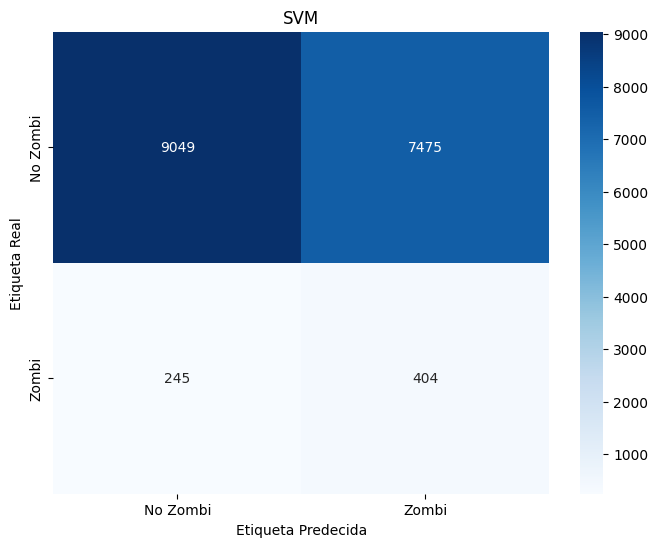

In [ ]:
# Predecir las etiquetas para el conjunto de testeo
y_pred = model_svm.predict(X_test)


df_metricas.loc["SVM", "Accuracy"] =  accuracy_score(y_test, y_pred)
df_metricas.loc["SVM", "Balanced Accuracy"] = balanced_accuracy(y_test, y_pred)
df_metricas.loc["SVM", "Precision"] = precision_score(y_test, y_pred)
df_metricas.loc["SVM", "Recall"] = recall_score(y_test, y_pred)
df_metricas.loc["SVM", "F1 Score"] = f1_score(y_test,y_pred)




# Calcular la matriz de confusión TEST
conf_matrix = confusion_matrix(y_test, y_pred)


# Nombres de las clases para el heatmap
class_names = ['No Zombi', 'Zombi']

# Crear el heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Añadir títulos y etiquetas para claridad
plt.title('SVM')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predecida')

# Mostrar la visualización
plt.show()

**Resultado usando como predictores las variables  financieros y el año**

In [ ]:
#df_metricas ratios financieros  absolutos

,Accuracy,Balanced Accuracy,Precision,Recall,F1 Score
SVM,0.550457,0.585062,0.051276,0.622496,0.094747


**Resultado usando como predictores los deltas financieros y el año**

In [ ]:
#df_metricas deltas

,Accuracy,Balanced Accuracy,Precision,Recall,F1 Score
SVM,0.460607,0.588703,0.049383,0.727273,0.092486


**Resultado usando como predictores Zombi y año:**

	Accuracy	Balanced Accuracy	Precision	Recall	F1 Score
  
SVM	0.942934	0.533654	0.131403	0.090909	**0.107468**


In [ ]:
#df_metricas con over sampling

In [ ]:
#df_metricas poly